# Notebook #3: Modelos de regresión

- En este notebook entrenaremos a los modelos que serán capaces de predecir el precio del alquiler, con los datos extraídos y transformados de las viviendas en venta en idealista.

- Importamos las librerías y soportes.

In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Librería para el acceso a variables y funciones
# -----------------------------------------------------------------------
import sys
sys.path.append("../")
from src import soporte_modelos as sm

- El primer paso consiste en cargar los datos ya estandarizados.

In [2]:
df = pd.read_pickle('../data/transformed/final_rent.pkl')
df.sample(5)

,precio,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,distrito
361,1100.0,911.616751,-1.0,5.0,1.0,1.731786,3.0,2.0,1.0,1.0,-1.0,-1.0,986.629118
142,850.0,911.616751,-1.0,4.0,1.0,0.112454,2.0,2.0,1.0,-1.0,-1.0,-1.0,986.629118
420,700.0,911.616751,-1.0,2.0,1.0,0.546909,1.0,1.0,-1.0,-1.0,-1.0,-1.0,921.986525
215,750.0,911.616751,-1.0,3.0,1.0,-0.440489,2.0,1.0,-1.0,-1.0,-1.0,-1.0,921.986525
228,900.0,938.211340,1.0,4.0,1.0,0.349429,3.0,2.0,1.0,-1.0,1.0,-1.0,986.629118


- Para nuestros modelos, utilizaremos el Decision Tree y otros tres modelos de ensamble: el Random Forest, el Gradient Boost y el XGBoost, que se usan en modelos de clasificación y de regresión.

- Nuestro problema es de regresión, por cuanto estamos intentando predecir valores continuos, en este caso, el alquiler. Un valor continuo es un tipo de dato numérico que puede tomar cualquier valor dentro de un rango determinado.

- Los Decision Tree son especialmente efectivos en problemas con interacciones no lineales y datos con diferentes tipos de variables (numéricas y categóricas). Son robustos frente a outliers y pueden gestionar conjuntos con valores faltantes. Sin embargo, son propensos al overfitting. Es entonces cuando podemos recurrir a los modelos de ensamble, para mejorar su estabilidad y precisión.

- El Random Forest puede funcionar mejor cuando tenemos conjuntos de datos grandes o mucho ruido en nuestros datos, pero puede ser menos efectivo para captar variaciones más pequeñas. Es más sencillo configurar los hiperparámetros. Es un modelo de Bagging, donde creamos un bosque (paralelo), no nos quedamos con un sólo árbol, y el resultado es la media de sus medias.

- Con Gradient Boosting, las predicciones suelen ser más acertadas, dado que la secuencia árboles tiende a reducir los errores. Normalmente tarda más para converger. Es más probable tener overfitting. En los modelos de Boosting, se aprende de los datos en la primera iteración (se predice la variable respuesta) pero en las posteriores, aprende de los errores cometidos, que son los que entran en el siguiente árbol, siendo el resultado final el del último árbol.

- La versión optimizada de este último modelo es el XGBoost, que utiliza paralelización (mejora tanto la velocidad como la eficiencia computacional), para maximizar la eficiencia y la precisión general del modelo.
________________________

- Como primer paso, separamos la X y la y de nuestro conjunto de datos.

In [3]:
X, y, X_train, X_test, y_train, y_test = sm.separar_datos(df, 'precio', train_size=0.7)

- Definimos un diccionario de hiperparámetros conjunto para todos los modelos.

In [4]:
params = {
    "tree": {
        'max_depth': [5],
        'min_samples_split': [10],
        'min_samples_leaf': [1]
    },
    "random_forest": {
        'n_estimators': [200],
        'max_depth': [15],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    "gradient_boosting": {
        'n_estimators': [300],
        'learning_rate': [0.01],
        'max_depth': [5],
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'subsample': [0.8]
    },
    "xgboost": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

- Antes de probar nuestros modelos, recordemos cómo interpretamos las métricas resultantes, específicamente el R2 y el RMSE, ambas son utilizadas para evaluar la precisión de los modelos de regresión.

- El R2 indica en qué porcentaje las variaciones en el modelo son explicadas por sus variables independientes. Con valores que van de 0 a 1, un valor más cercano a 1 indica un mejor ajuste del modelo.

- Por otro lado, el RMSE mide la magnitud de los errores de predicción, representando la desviación estándar de las diferencias entre los valores predichos y los observados. Un valor más bajo de RMSE indica una mejor predicción. 

- Con esto claro, empezamos las pruebas.

## Decision Tree

In [140]:
modelo_tree, metricas_tree = sm.entrenar_modelo(X, y["precio"].values, X_test, y_test, params["tree"], 'DecisionTree')

Los mejores parámetros para el modelo DecisionTree son:
    {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
    

    Y sus mejores métricas son:


,R2,RMSE,MSE,MAE
Train,0.481288,167.850978,28173.950828,123.259154
Test,0.489699,159.541549,25453.505997,116.976125


In [56]:
print(f"El precio medio de las viviendas en el conjunto de datos es de: {round(df['precio'].mean())} euros.")

El precio medio de las viviendas en el conjunto de datos es de: 911 euros.


- El resultado es malo, especialmente el R2, que nos está indicando que, las variables del modelo sólamente explican en un 49% los cambios en el modelo.

- En el caso del RSME, tenemos una desviación de aproximadamente 160 euros, que es alta, considerando que la media del conjunto de datos es de 911 euros.

- No tenemos overfitting, es decir, el modelo no está aprendiéndose los datos.

## Random Forest

In [141]:
modelo_rf, metricas_rf = sm.entrenar_modelo(X, y["precio"].values, X_test, y_test, params["random_forest"], 'RandomForest')

Los mejores parámetros para el modelo RandomForest son:
    {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    

    Y sus mejores métricas son:


,R2,RMSE,MSE,MAE
Train,0.893736,75.972002,5771.745086,56.140226
Test,0.876608,78.452079,6154.728728,58.442645


- En este caso, los resultados son muy buenos, con un R2 alto y un RMSE menor. En el caso del R2, quiere decir que, casi el 90% de los cambios en la variable respuesta (precio) pueden ser explicadas por el modelo, mientras que, la otra mitad se debe a factores no capturados por el modelo.

- Veamos la importancia de nuestras variables predictoras, graficándolas para una interpretación más sencilla:

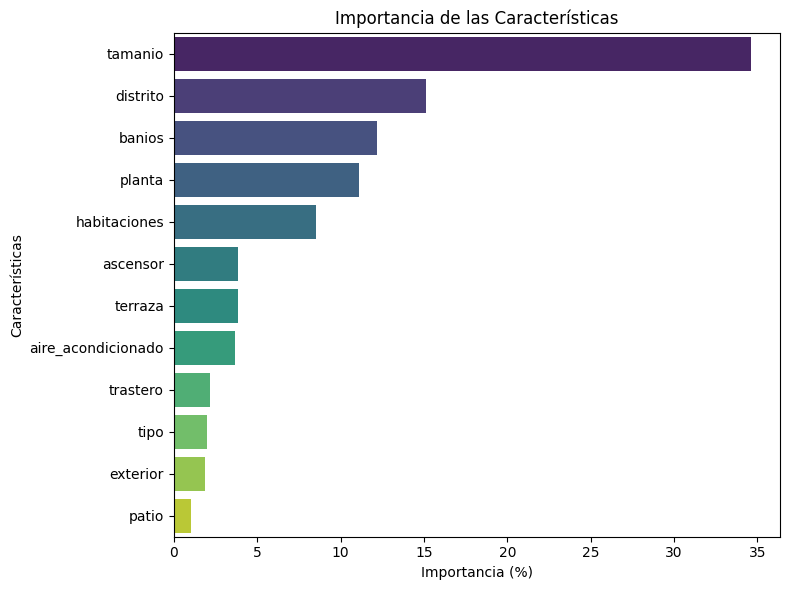

,Importancia
tamanio,34.621694
distrito,15.111444
banios,12.173888
planta,11.095948
habitaciones,8.505974
ascensor,3.874313
terraza,3.854845
aire_acondicionado,3.677657
trastero,2.200286
tipo,1.983536


In [111]:
sm.importancia_caracteristicas(modelo_rf, X)

- Vemos que, con diferencia, el tamaño es la variable predictora más importante, explicando casi un 35% de los cambios.

- Le siguen el distrito, baños y planta, que explican aproximadamente entre el 10 y 15% de los cambios. Las habitaciones representan un 8%.

- Tenemos un grupo que representa entorno al 9%, que son ascensor, aire acondicionado y habitaciones, y otro final que no llega al 2% e incluyen trastero, exterior, tipo y patio.

- Vamos a eliminar este último grupo y probar si obtenemos un mejor resultado.

In [92]:
columnas_a_eliminar = ['trastero', 'exterior', 'tipo', 'patio']

X_train_reducida = X_train.drop(columns=columnas_a_eliminar)
X_test_reducida = X_test.drop(columns=columnas_a_eliminar)

- Ahora reentrenamos al modelo, ajustando ligeramente los parámetros.

In [99]:
nuevos_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

In [112]:
modelo_rf_v2, metricas_rf_v2 = sm.entrenar_modelo(X_train_reducida, y_train["precio"].values, X_test_reducida, y_test, nuevos_params, 'RandomForest')

Los mejores parámetros para el modelo RandomForest son:
    {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
    

    Y sus mejores métricas son:


,R2,RMSE,MAE,MSE
Train,0.577975,154.039635,112.777833,23728.209249
Test,0.228629,196.151831,144.888367,38475.540623


- Vemos que, las métricas han empeorado significativamente, así que, no sería este el acercamiento correcto (eliminar variables). Vemos que, además, tenemos muchísimo overfitting.

## Gradient Boost

In [108]:
modelo_gb, metricas_gb = sm.entrenar_modelo(X, y["precio"].values, X_test, y_test, params["gradient_boosting"], 'GradientBoost')

Los mejores parámetros para el modelo GradientBoost son:
    {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
    

    Y sus mejores métricas son:


,R2,RMSE,MAE,MSE
Train,0.698979,127.867230,91.546548,16350.028629
Test,0.678853,126.564694,90.959479,16018.621708


- Damos un paso atrás respecto a la primera iteración del Random Forest. Vemos que, tanto el R2 como el RMSE han empeorado. Aunque el R2 no es del todo malo, un 0,68, el RMSE es elevado y tendría un efecto negativo elevado sobre los cálculos de rentabilidad.

- No hay overfitting.

## XGBoost

In [106]:
modelo_xgb, metricas_xgb = sm.entrenar_modelo(X, y["precio"].values, X_test, y_test, params["xgboost"], 'XGBRegressor')

Los mejores parámetros para el modelo XGBRegressor son:
    {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
    

    Y sus mejores métricas son:


,R2,RMSE,MAE,MSE
Train,0.753317,115.752546,82.436713,13398.651943
Test,0.740434,113.784846,81.658474,12946.991109


- Respecto al Gradient Boosting, mejoramos las métricas, con un R2 que explica el 74% de los cambios, sin embargo, se alejan de los resultados obtenidos por el Random Forest, con un RMSE 38 superior.

- Cuando consideramos el impacto sobre la rentabilidad, esto es significativo.

## Modelo elegido

- Dadas las métricas que hemos conseguido, el mejor modelo es Random Forest, con lo cual, vamos a reentrenar al modelo con la totalidad de los datos, y guardar el objeto.

In [13]:
modelo_final_rf, metricas_final_rf = sm.entrenar_modelo(X, y["precio"].values, X_test, y_test, params["random_forest"], 'RandomForest', modelo_final=True, X=X, y=y)

Modelo final entrenado con todos los datos.


,R2,RMSE,MSE,MAE
Total,0.893736,75.972002,5771.745086,56.140226


In [127]:
#with open('../transformers/model.pkl', 'wb') as f:
#      pickle.dump(modelo_final_rf, f)